In [1]:
import pandas as pd
import cluj_tools as ct

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [2]:
matchup_end_date, matchupPeriod = ct.matchup_end_date()

Matchup end date is 2020-03-01
Matchup period is 18


In [3]:
rosters = ct.get_rosters(matchupPeriod)

### Get Boxscore data to calculate octys

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [6]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm / boxscores.fta
boxscores['fg_pct'] = boxscores.fgm / boxscores.fga

In [7]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [8]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(463, 21)

In [9]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [10]:
octy_counts.head()

,espn_name,octy_count
0,Anthony Davis,14
1,James Harden,12
2,Joel Embiid,11
3,Kawhi Leonard,10
4,Nikola Jokic,9


In [11]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [12]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(189, 4)

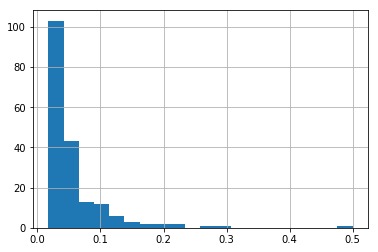

In [13]:
merged.octy_pct.hist(bins=20)

In [14]:
merged.head(30)

,espn_name,octy_count,game_count,octy_pct
153,P.J. Washington,1,2,0.500000
0,Anthony Davis,14,48,0.291667
2,Joel Embiid,11,42,0.261905
3,Kawhi Leonard,10,44,0.227273
1,James Harden,12,54,0.222222
167,Juan Toscano-Anderson,1,5,0.200000
30,Kyrie Irving,4,20,0.200000
9,John Collins,6,33,0.181818
6,Brandon Ingram,8,49,0.163265
4,Nikola Jokic,9,57,0.157895


In [15]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(189, 6)

In [16]:
rosters_merge.groupby('teamId')['octy_pct'].mean().sort_values()

teamId
9.0     0.045649
1.0     0.051686
2.0     0.051975
12.0    0.055137
3.0     0.057443
11.0    0.057836
5.0     0.060552
6.0     0.065918
8.0     0.066121
10.0    0.066642
7.0     0.067442
4.0     0.091369
Name: octy_pct, dtype: float64

In [17]:
rosters_merge.groupby('teamId')['octy_count'].sum().sort_values()

teamId
2.0     19
1.0     23
8.0     24
9.0     24
12.0    24
11.0    27
3.0     29
6.0     29
5.0     33
7.0     37
10.0    41
4.0     55
Name: octy_count, dtype: int64

In [19]:
rosters_merge.loc[rosters_merge.teamId == 4]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
2,Joel Embiid,11,42,0.261905,Joel Embiid,4.0
3,Kawhi Leonard,10,44,0.227273,Kawhi Leonard,4.0
11,Pascal Siakam,7,46,0.152174,Pascal Siakam,4.0
29,Kristaps Porzingis,4,44,0.090909,Kristaps Porzingis,4.0
33,Zach LaVine,5,58,0.086207,Zach LaVine,4.0
44,Goran Dragic,3,46,0.065217,Goran Dragic,4.0
45,Andrew Wiggins,3,47,0.063830,Andrew Wiggins,4.0
50,Lonzo Ball,3,49,0.061224,Lonzo Ball,4.0
61,Jonas Valanciunas,3,54,0.055556,Jonas Valanciunas,4.0
66,Dennis Schroder,3,56,0.053571,Dennis Schroder,4.0


In [18]:
rosters_merge.loc[rosters_merge.teamId == 10]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
9,Nikola Jokic,9,57,0.157895,Nikola Jokic,10.0
12,Josh Richardson,6,44,0.136364,Josh Richardson,10.0
20,Myles Turner,5,47,0.106383,Myles Turner,10.0
32,Mikal Bridges,5,58,0.086207,Mikal Bridges,10.0
40,Miles Bridges,4,56,0.071429,Miles Bridges,10.0
68,Maxi Kleber,3,57,0.052632,Maxi Kleber,10.0
82,PJ Washington,2,47,0.042553,PJ Washington,10.0
84,Derrick Rose,2,47,0.042553,Derrick Rose,10.0
91,Giannis Antetokounmpo,2,51,0.039216,Giannis Antetokounmpo,10.0
127,Elfrid Payton,1,36,0.027778,Elfrid Payton,10.0


In [19]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(20)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
0,P.J. Washington,1,1,1.000000,NaN,NaN
14,Josh Jackson,1,8,0.125000,NaN,NaN
20,Kadeem Allen,1,10,0.100000,NaN,NaN
24,Jonathan Isaac,3,32,0.093750,NaN,NaN
26,Justise Winslow,1,11,0.090909,NaN,NaN
33,Lauri Markkanen,4,46,0.086957,NaN,NaN
41,PJ Dozier,1,15,0.066667,NaN,NaN
49,Jabari Parker,2,33,0.060606,NaN,NaN
52,Josh Okogie,3,51,0.058824,NaN,NaN
63,Maxi Kleber,3,54,0.055556,NaN,NaN
